# Homework 2

In [62]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
%matplotlib inline

### Get the data from cryptowat.ch

In [46]:
def get_data(token):
    if token in ['ETH', 'SOL','USDT','FLOW']:
        server="kraken"
    else: 
        server="coinbase-pro"
    res = requests.get(
        f'https://api.cryptowat.ch/markets/{server}/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    print(token)
    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df

In [47]:
tokens = ['ETH', 'SOL', 'AVAX','USDT','FLOW']

In [55]:
df = pd.concat([
    get_data(token)
    for token in tokens
])

ETH
SOL
AVAX
USDT
FLOW


In [75]:
df.head()

,ts,open,high,low,close,volume,volumeUSD,token
0,2021-11-22 00:00:00,4316.41,4339.25,4250.00,4263.51,2275.049242,9.768715e+06,ETH
1,2021-11-22 01:00:00,4265.39,4269.98,4210.00,4234.28,5177.368685,2.191977e+07,ETH
2,2021-11-22 02:00:00,4234.28,4244.14,4173.00,4217.00,2137.011937,8.986250e+06,ETH
3,2021-11-22 03:00:00,4218.09,4219.48,4163.64,4191.83,1377.294702,5.782201e+06,ETH
4,2021-11-22 04:00:00,4191.82,4211.21,4130.43,4166.58,1762.426504,7.340491e+06,ETH


### Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume

In [60]:
df.groupby("token")["volumeUSD"].sum().to_frame().sort_values(by="volumeUSD",ascending=False)

,volumeUSD
token,
ETH,3.877596e+09
USDT,3.386274e+09
AVAX,3.309917e+09
SOL,6.547171e+08
FLOW,8.345695e+07


### Add a column that calculates the close price ratio between ETH and SOL for each house (i.e. close price of ETH / close price of SOL for each period)

In [79]:
# add a column called ETH_SOL_Ratio


ETH_SOL_Ratio=pd.merge(df[df["token"]=="ETH"][["ts","close"]].rename(columns={"close":"ETH_close"}),
                      df[df["token"]=="SOL"][["ts","close"]].rename(columns={"close":"SOL_close"}),on="ts",how="outer"
                      )

ETH_SOL_Ratio["ETH_SOL_Ratio"]=ETH_SOL_Ratio["ETH_close"]/ETH_SOL_Ratio["SOL_close"]

df=pd.merge(df,ETH_SOL_Ratio[["ts","ETH_SOL_Ratio"]],on="ts",how="left")

In [82]:
df.head()

,ts,open,high,low,close,volume,volumeUSD,token,ETH_SOL_Ratio
0,2021-11-22 00:00:00,4316.41,4339.25,4250.00,4263.51,2275.049242,9.768715e+06,ETH,18.501606
1,2021-11-22 01:00:00,4265.39,4269.98,4210.00,4234.28,5177.368685,2.191977e+07,ETH,18.728294
2,2021-11-22 02:00:00,4234.28,4244.14,4173.00,4217.00,2137.011937,8.986250e+06,ETH,18.564825
3,2021-11-22 03:00:00,4218.09,4219.48,4163.64,4191.83,1377.294702,5.782201e+06,ETH,18.785650
4,2021-11-22 04:00:00,4191.82,4211.21,4130.43,4166.58,1762.426504,7.340491e+06,ETH,18.876365


### Change the name of the `volume` and `volumeUSD` columns to `volumeBase` and `volumeTerm`

In [84]:
df.rename(columns={"volume":"volumeBase","volumeUSD":"volumeTerm"},inplace=True)
print(df.columns)

Index(['ts', 'open', 'high', 'low', 'close', 'volumeBase', 'volumeTerm',
       'token', 'ETH_SOL_Ratio'],
      dtype='object')


### create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of  200 rows and 5 columns)

In [94]:
crypto_close=df[["ts","close","token"]].pivot(index="ts",columns="token",values="close")

In [95]:
crypto_close.head()

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,128.67,4263.51,14.150,230.44,1.0009
2021-11-22 01:00:00,134.85,4234.28,13.621,226.09,1.0010
2021-11-22 02:00:00,132.54,4217.00,13.753,227.15,1.0009
2021-11-22 03:00:00,133.38,4191.83,13.652,223.14,1.0009
2021-11-22 04:00:00,136.29,4166.58,13.581,220.73,1.0009


### calculate the hour by hour log return of the close price of each token (return is calculated by $np.log(price_t / price_{t-1})$)

In [101]:
df["log_return"]=df.groupby("token")["close"].apply(lambda x:np.log(x/x.shift(1)))

In [104]:
df.log_return.head()

0         NaN
1   -0.006879
2   -0.004089
3   -0.005987
4   -0.006042
Name: log_return, dtype: float64

In [108]:
#### the other method

In [110]:
crypto_log_return=crypto_close.apply(lambda x:np.log(x/x.shift(1)),axis=0)

In [111]:
crypto_log_return.head()

token,AVAX,ETH,FLOW,SOL,USDT
ts,,,,,
2021-11-22 00:00:00,NaN,NaN,NaN,NaN,NaN
2021-11-22 01:00:00,0.046912,-0.006879,-0.038102,-0.019057,0.0001
2021-11-22 02:00:00,-0.017279,-0.004089,0.009644,0.004677,-0.0001
2021-11-22 03:00:00,0.006318,-0.005987,-0.007371,-0.017811,0.0000
2021-11-22 04:00:00,0.021583,-0.006042,-0.005214,-0.010859,0.0000


### calculate the correlation of the tokens using the table above

In [113]:
crypto_corr=crypto_log_return.corr()

In [114]:
crypto_corr

token,AVAX,ETH,FLOW,SOL,USDT
token,,,,,
AVAX,1.000000,0.633440,0.382025,0.624228,0.021606
ETH,0.633440,1.000000,0.564051,0.735917,-0.045571
FLOW,0.382025,0.564051,1.000000,0.463832,-0.156326
SOL,0.624228,0.735917,0.463832,1.000000,0.059553
USDT,0.021606,-0.045571,-0.156326,0.059553,1.000000


### visualize the correlation in a matplpotlib plot

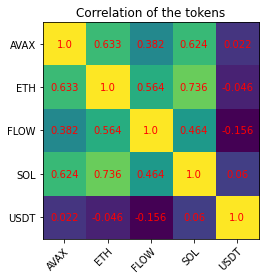

In [123]:
fig, ax = plt.subplots()
im = ax.imshow(crypto_corr)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(crypto_corr.columns)), labels=crypto_corr.columns)
ax.set_yticks(np.arange(len(crypto_corr.index)), labels=crypto_corr.index)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(crypto_corr.columns)):
    for j in range(len(crypto_corr.index)):
        text = ax.text(j, i, crypto_corr.apply(lambda x:round(x,3)).iloc[i,j],
                       ha="center", va="center", color="r")

ax.set_title("Correlation of the tokens")
fig.tight_layout()
plt.show()